<a href="https://colab.research.google.com/github/jqhoogland/implicit-self-regularization/blob/master/rmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch transformers ipywidgets powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# from typing import Literal

import numpy as np
import torch as t
from torch import nn
import ipywidgets as widgets
from matplotlib import pyplot as plt
import powerlaw

In [5]:
def marchenko_pastur_pdf(x_min: float, x_max: float, Q: float, sigma=1):
    y = 1 / Q
    x = np.arange(x_min, x_max, 0.001)

    b = np.power(sigma * (1 + np.sqrt(1 / Q)), 2) # Largest eigenvalue
    a = np.power(sigma * (1 - np.sqrt(1 / Q)), 2) # Smallest eigenvalue
    return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))

# @widgets.interact(x_min=0., x_max=4., Q=(0.5, 20.))
def plot_marchenko_pastur_pdf(x_min: float, x_max: float, Q: float, sigma=1):
    x, y = marchenko_pastur_pdf(x_min, x_max, Q, sigma)
    plt.plot(x, y)

In [6]:
def calc_sigma(Q, evs):
    lmax = np.max(evs)
    inv_sqQ = 1.0/np.sqrt(Q)
    sigma_2 = lmax/np.square(1+inv_sqQ)
    sigma = np.sqrt(sigma_2)
    return sigma

$$\sigma^{2}=\lambda_{max}\left(1+\dfrac{1}{\sqrt{Q}}\right)^{-2}$$

In [7]:
def calc_lambda_plus(Q: float, sigma: float):
    return np.power(sigma*(1 + np.sqrt(1/Q)),2)

def calc_lambda_minus(Q: float, sigma: float):
    return np.power(sigma*(1 - np.sqrt(1/Q)),2)

def calc_sigma(Q: float, evs: np.ndarray):
    lmax = np.max(evs)
    inv_sqQ = 1.0 / np.sqrt(Q)
    sigma_2 = lmax / np.square(1 + inv_sqQ)
    sigma = np.sqrt(sigma_2)

    return sigma

def get_Q(W: np.ndarray):
    M, N = W.shape

    if M > N:
        M, N = N, M

    return N / M

def get_svs_squared(rect_matrix: np.ndarray):
    _, svs, _ = np.linalg.svd(rect_matrix)

    return svs * svs


In [8]:
def plot_ESD_and_fit(rect_matrix: np.ndarray, num_spikes=0, Q=None, sigma=None,
                     alpha=0.25, color='blue', skip=False, verbose=True):
    """Plot histogram of eigenvalues, for Q, and fit Marchenk Pastur.  
    If no sigma, calculates from maximum eigenvalue (minus spikes)
    Can read keras weights from model if specified.  Does not read PyTorch"""
    eigenvalues = get_svs_squared(rect_matrix)
   
    if skip:
        plt.hist(eigenvalues, bins=100, alpha=alpha, color=color, density=True, label=r'$\rho_{emp}(\lambda)$')
        return
        
    # sort, descending order, minus a few max eigenvalues (the spikes)
    evals = np.sort(eigenvalues)[::-1][num_spikes:]

    if Q is None:
        Q = get_Q(rect_matrix)

    if sigma is None:
        sigma = calc_sigma(Q, evals)
        
    percent_mass = 100.0 * num_spikes / len(evals)

    x_min, x_max =  0, np.max(evals)

    xs, ys = marchenko_pastur_pdf(x_min, x_max, Q, sigma)
    print(x_min, x_max, Q, sigma, xs)

    if verbose:
        print("% spikes outside bulk {0:.2f}".format(percent_mass))
        print("% sigma {0:.4f}".format(sigma))

    fig,ax = plt.subplots()
    ax.plot(xs, ys, linewidth=1, color = 'r', label="MP fit")
    ax2 = ax.twinx()
    ax2.hist(eigenvalues, bins=100, alpha=alpha, color=color, density=True, label=r'$\rho_{emp}(\lambda)$')
    plt.title(" ESD, MP Sigma={}".format( sigma))
    return sigma

In [9]:
def gen_matrix(N: int, M: int, sigma=1.):
    return np.random.normal(size=(N, M), loc=0., scale=sigma**2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


0 4431.973952795749 4.0 44.38204818665487 [0.000000e+00 1.000000e-03 2.000000e-03 ... 4.431971e+03 4.431972e+03
 4.431973e+03]
% spikes outside bulk 0.00
% sigma 44.3820


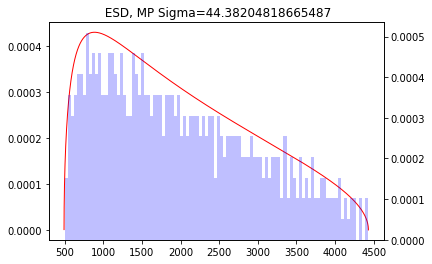

In [10]:
test_matrix_1 = gen_matrix(500, 2000)
plot_ESD_and_fit(test_matrix_1)
plt.show()

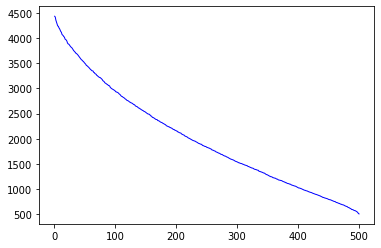

In [11]:
def scree_plot(matrix: np.ndarray, color='blue',label=''):    
    evs = get_svs_squared(matrix)
    eigvals = np.flip(np.sort(evs), axis=0)
    sing_vals = np.arange(len(eigvals)) + 1
    plt.plot(sing_vals, eigvals, color, linewidth=1,label=label)

scree_plot(test_matrix_1)

In [12]:
def get_mu(alpha):
    if (alpha >= 2.0 and alpha <= 3.0):
        mu = 2.0
    elif (alpha < 2.0):
        mu = 2.0*(alpha - 1.0)
    elif (alpha > 3.0):
        mu = alpha - 1.0
    return mu

def best_dist(fit):
    distName = 'power_law'
    dist = "PL"

    R, p = fit.distribution_compare('truncated_power_law', 'power_law', normalized_ratio=True)
    if R>0 and p <= 0.05:
        distName = 'truncated_power_law'
        dist = 'TPL'
        
    R, p = fit.distribution_compare(distName, 'exponential', normalized_ratio=True)
    if R<0 and p <= 0.05:
        dist = 'EXP'
        return dist

    R, p = fit.distribution_compare(distName, 'stretched_exponential', normalized_ratio=True)
    if R<0 and p <= 0.05:
        dist = 'S_EXP'
        return dist
        
    R, p = fit.distribution_compare(distName, 'lognormal', normalized_ratio=True)
    if R<0 and p <= 0.05:
        dist = 'LOG_N'
        return dist

    return dist

def fit_powerlaw(evals, verbose=True):
    fit = powerlaw.Fit(evals, xmax=np.max(evals))
    return [fit.alpha, fit.D, best_dist(fit)]

def pareto_pdf(x_min: float, x_max: float, mu=1., scale=1.):
    print(mu, scale)
    xs = np.arange(x_min, x_max, 0.001)
    ys = mu * scale**mu / xs**(mu+1)
    return xs, ys 


In [15]:
def fit_and_plot_powerlaw_with_bulk(rect_matrix: np.ndarray, Q=None, sigma=None,
                     alpha=0.25, color='blue', skip=False, verbose=True):
    eigenvalues = get_svs_squared(rect_matrix)
   
    if skip:
        plt.hist(eigenvalues, bins=100, alpha=alpha, color=color, density=True, label=r'$\rho_{emp}(\lambda)$')
        return
        
    # sort, descending order, minus a few max eigenvalues (the spikes)
    evals = np.sort(eigenvalues)[::-1]

    fit = powerlaw.Fit(evals, xmax=np.max(evals))
    alpha, D, dist = fit.alpha, fit.D, best_dist(fit)
    mu = get_mu(alpha)

    scale = 1.

    x_min, x_max = 0, np.max(evals)

    if dist == "PL":
        print(mu, scale)
        xs, ys = pareto_pdf(x_min, x_max, mu, scale)
    else:
        raise NotImplementedError("Non-PL fit not supported")

    if verbose:
        print("% mu {0:.4f} scale {0:.4f}".format(mu, scale))

    fig, ax = plt.subplots()
    ax.plot(np.log(xs), np.log(ys), linewidth=1, color = 'r', label="MP fit")
    ax2 = ax.twinx()
    ax2.hist(np.log(eigenvalues), log=True, bins=100, alpha=mu, density=True, label=r'$\rho_{emp}(\lambda)$')
    plt.title(" ESD, MP Sigma={}".format( sigma))
    plt.show()
    return

In [14]:
# HT_Dist = Literal["PL", "TPL", "EXP", "S_EXP", "LOG_N"]

def gen_heavy_tail_matrix(N: int, M: int, alpha=6., mu=None, scale=1., sigma=0, mean=1, dist="PL"):
    if mu is None:
        mu = get_mu(alpha)

    if dist == "PL":
        return (np.random.pareto(mu, size=(N, M)) + 1) * scale

    raise NotImplementedError()
  


In [ ]:
test_ht_matrix = gen_heavy_tail_matrix(150, 300, mu=1.75)
fit_and_plot_powerlaw_with_bulk(test_ht_matrix)

Calculating best minimal value for power law fit


Assuming nested distributions


1.8227904135171826 1.0
1.8227904135171826 1.0
